In [1]:
# use creditcard and model.hs file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df =  pd.read_csv(r"D:\Documents\Downloads\creditcard.csv")

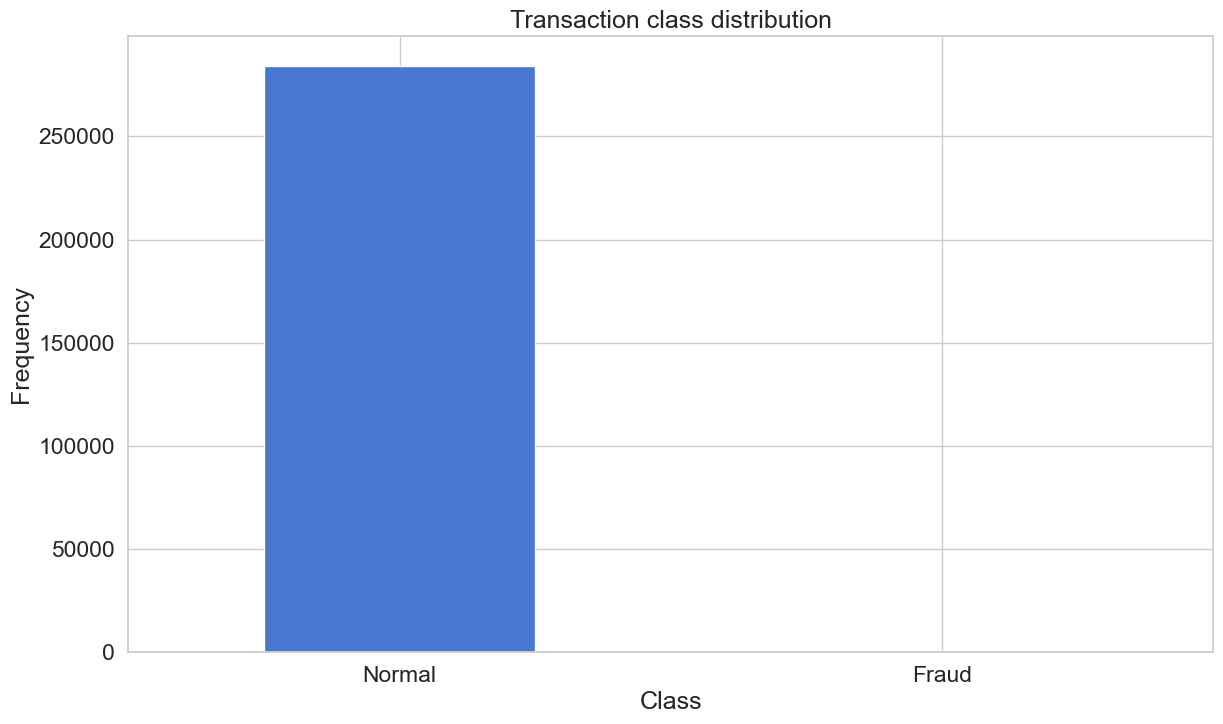

In [4]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [6]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [8]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [9]:

nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/10
7108/7108 [==============================] - 22s 3ms/step - loss: 0.8049 - accuracy: 0.6140 - val_loss: 0.7760 - val_accuracy: 0.6858
Epoch 2/10
7108/7108 [==============================] - 21s 3ms/step - loss: 0.7340 - accuracy: 0.6928 - val_loss: 0.7579 - val_accuracy: 0.7027
Epoch 3/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7218 - accuracy: 0.7072 - val_loss: 0.7516 - val_accuracy: 0.7091
Epoch 4/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7144 - accuracy: 0.7199 - val_loss: 0.7445 - val_accuracy: 0.7189
Epoch 5/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7106 - accuracy: 0.7242 - val_loss: 0.7421 - val_accuracy: 0.7254
Epoch 6/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7088 - accuracy: 0.7245 - val_loss: 0.7431 - val_accuracy: 0.7236
Epoch 7/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7077 - accuracy: 0.7254 - val_loss: 0.7403 - val_ac

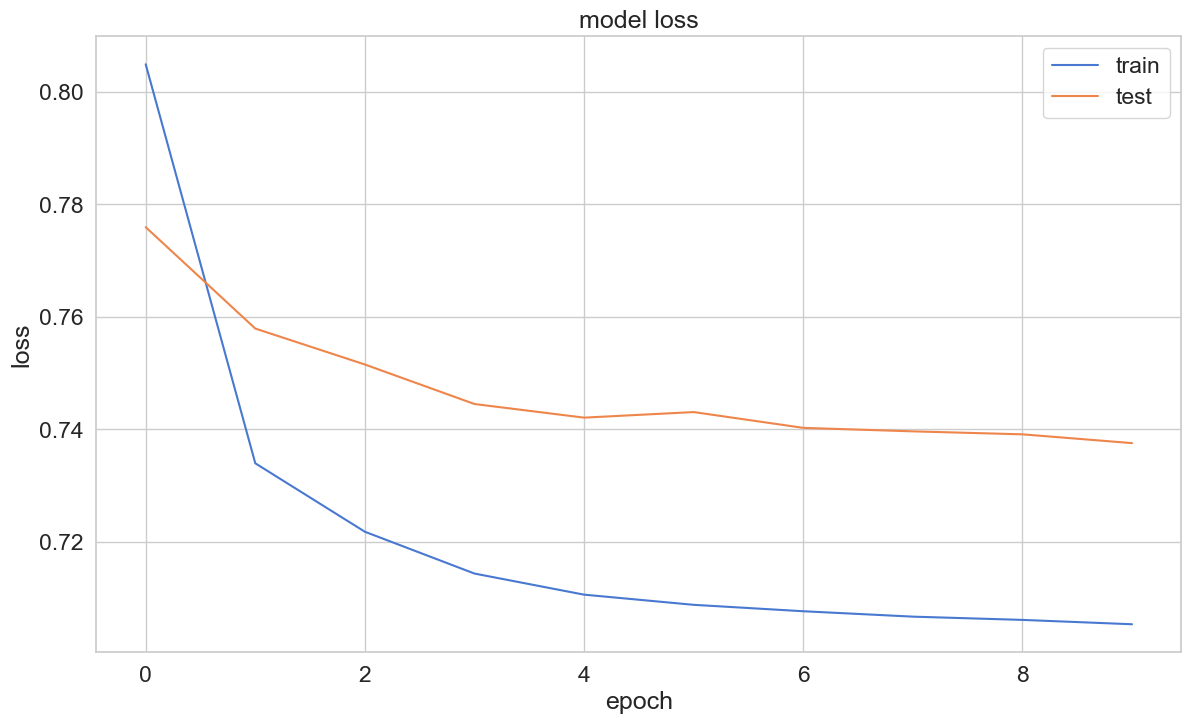

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [11]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 4s 2ms/step


In [12]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [13]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.736662,0.001720
std,3.456772,0.041443
min,0.041953,0.000000
25%,0.240758,0.000000
50%,0.387357,0.000000
75%,0.614884,0.000000
max,261.442601,1.000000


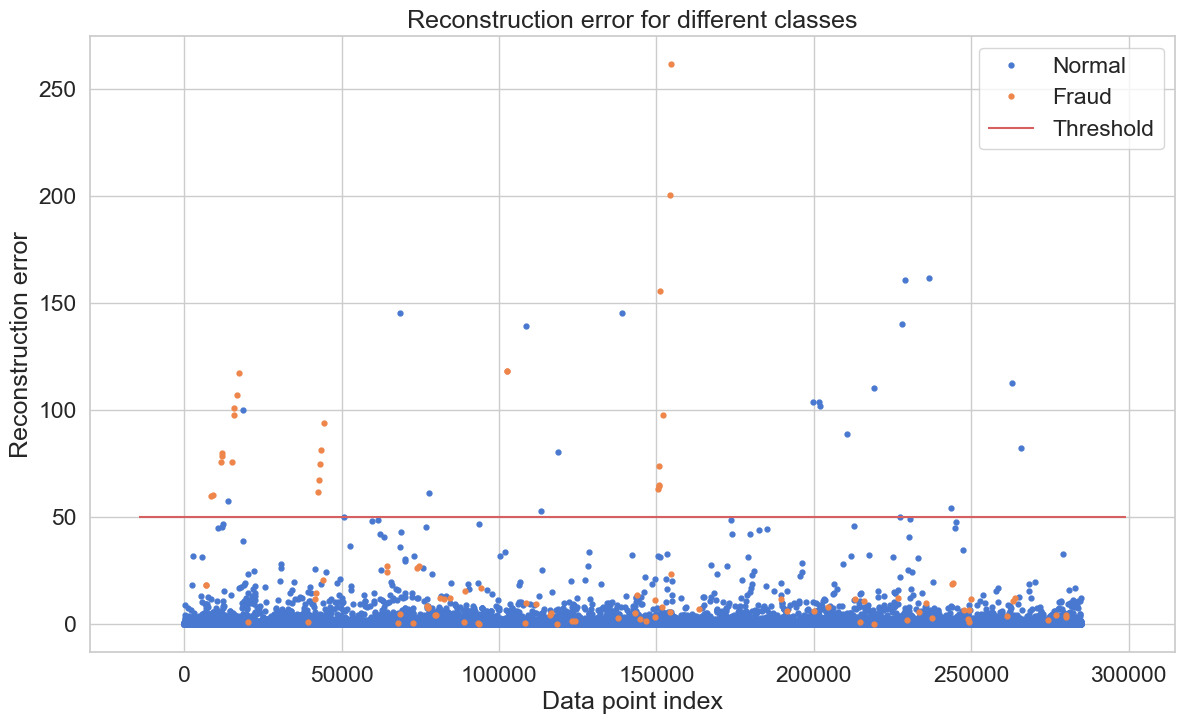

In [14]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [15]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

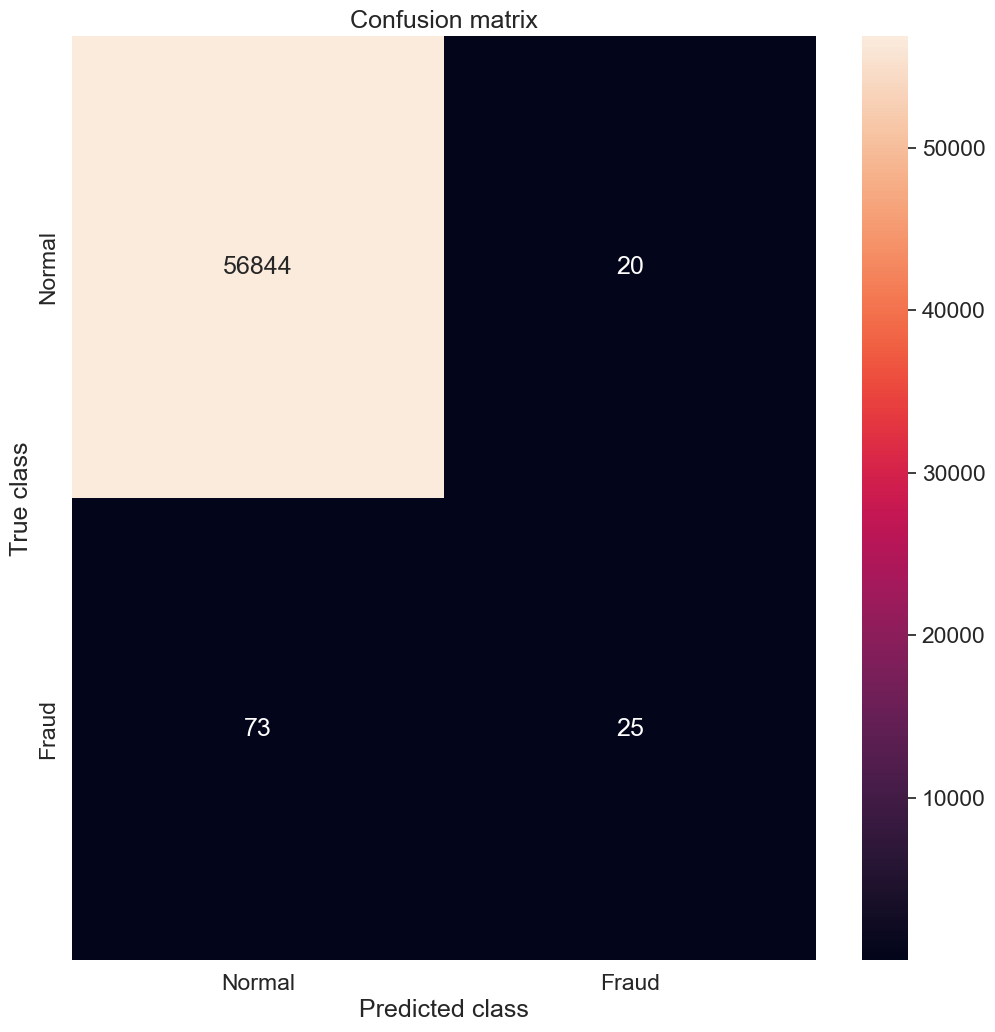

In [16]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [17]:
error_df['pred'] = y_pred

In [18]:
print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983673326077034
Recall: 0.25510204081632654
Precision: 0.5555555555555556
